# Data preparation

## Load data

In [208]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

data = pd.read_csv('./data/train.csv')
data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Study correlation

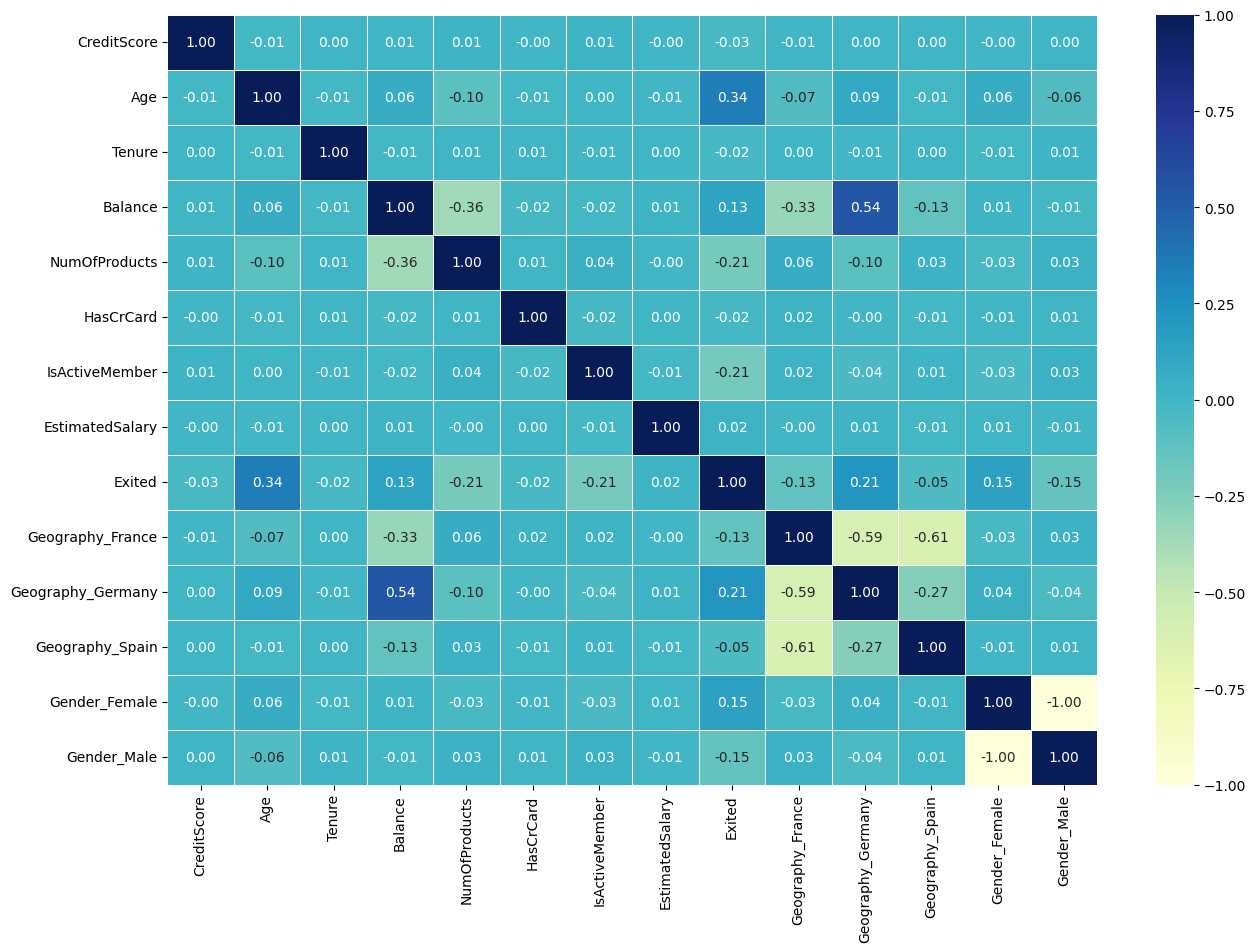

In [209]:
corr_mat = pd.get_dummies(data.drop(['id', 'CustomerId', 'Surname'], axis=1)).corr()
fig , ax = plt.subplots(figsize = (15 , 10))
ax = sns.heatmap(corr_mat , annot=True, linewidths=0.5, fmt="0.2f", cmap="YlGnBu")

## Drop outliers

Drop outliers so that the model can be more accurate.

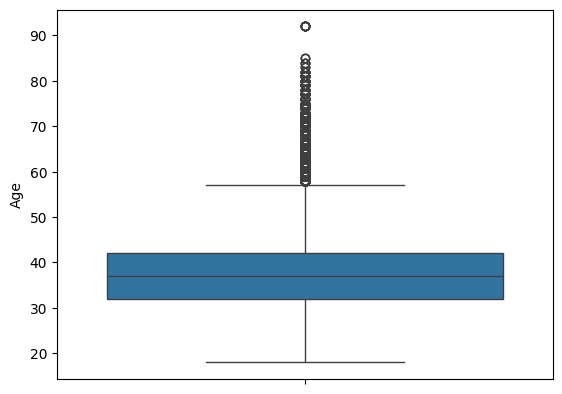

In [210]:
sns.boxplot(data['Age'])
data['Age'].describe()

# Drop outliers
data = data[data['Age'] <= 55 ]

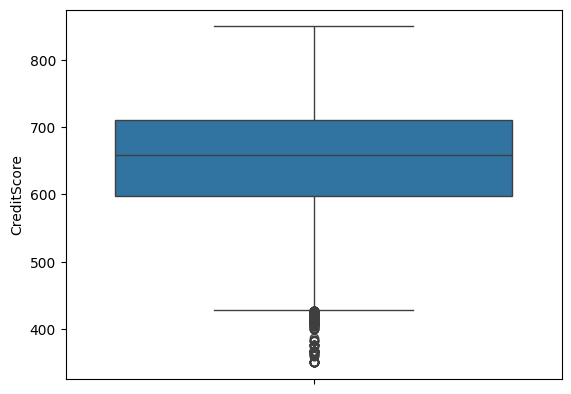

In [211]:
sns.boxplot(data['CreditScore'])
data = data[data['CreditScore'] >= 450]

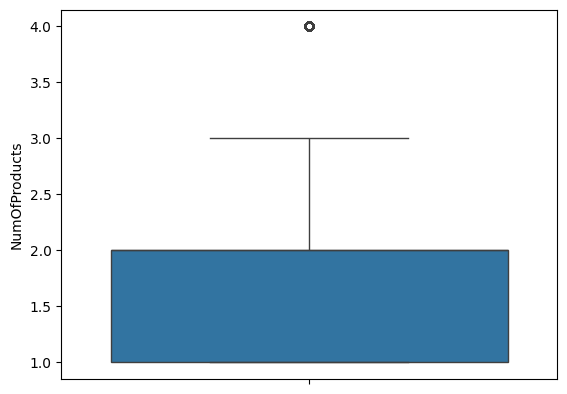

In [212]:
sns.boxplot(data['NumOfProducts'])
data = data[data['NumOfProducts'] <= 3 ]

## Train

In [213]:
features = [
    'CreditScore', 
    'Age', 
    'Tenure', 
    'Balance', 
    'NumOfProducts', 
    'EstimatedSalary', 
    'Geography', 
    'Gender', 
    'HasCrCard', 
    'IsActiveMember'
]
x_data = pd.get_dummies(data[features]).astype(np.float32)
y_data = (data['Exited']).astype(np.float32)

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

x_train, x_, y_train, y_ = train_test_split(x_data, y_data, test_size=0.33, random_state=1)

In [214]:
def evaluate(model):
    predictions = model.predict(x_)
    predictions = predictions.reshape(1, len(predictions))[0]
    predictions = np.array(list(map(lambda p: 1 if p >= 0.5 else 0, predictions)))

    miss_rate = round(np.mean(predictions !=  y_) * 100 , 2)
    print(f'Miss rate: {miss_rate}%')

    return miss_rate


In [215]:

# Perform Grid search to find best hyper params for XGBClassifier
# Takes very long to run so just use the output at the bottom

# model = XGBClassifier()

# param_grid = {
#     'n_estimators': [50, 100, 200, 1000],
#     'learning_rate': [0.01, 0.1, 0.2], 
#     'max_depth': [2**i for i in range(0, 5)], 
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

# grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
# grid_search.fit(x_train, y_train)

# best_params = grid_search.best_params_
# {
#     'colsample_bytree': 0.8,
#     'learning_rate': 0.1,
#     'max_depth': 4,
#     'n_estimators': 200,
#     'subsample': 1.0
# }

In [216]:
models = []

model_xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, colsample_bytree=0.8)
model_xgb.fit(x_train, y_train, eval_set=[(x_, y_)], verbose=False)
models.append(model_xgb)

# Evaluate

In [217]:
miss_rates = []

for model in models:
    miss_rates.append(evaluate(model))

Miss rate: 13.09%


In [218]:
best_model = models[np.argmin(miss_rates)]

# Output

In [219]:
test_data = pd.read_csv("./data/test.csv")
x_test = pd.get_dummies(test_data[features]).astype('float32')

x_test = scaler.transform(x_test)

test_pred = best_model.predict(x_test)
[test_pred] = test_pred.reshape(1, len(test_pred))
test_pred = np.round(test_pred, 1)
output = pd.DataFrame({'id': test_data.id, 'Exited': test_pred})
output.to_csv('./data/bank-churn-submission.csv', index=False)